In [37]:
import requests
import pandas as pd
import json
from pandas.tseries.offsets import MonthEnd

In [79]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36',
    'Content-Type': 'application/json'
}

In [80]:
!mkdir data

In [125]:
with open("data/metrics.csv", "wb") as out:
    out.write(requests.get("http://stat.customs.gov.ru/api/Dictionary/UnloadDictionary?code=NSIEI&type=Csv", 
                           headers=headers).content)
metrics = pd.read_csv("data/metrics.csv", sep="\t", dtype=str).rename(columns={'KOD':'edizm', 'NAME': 'metric_name'}).drop("SHORT_NAME", axis=1)
metrics.head()

,edizm,metric_name
0,006,МЕТР
1,055,КВАДРАТНЫЙ МЕТР
2,166,КИЛОГРАММ
3,163,ГРАММ
4,113,КУБИЧЕСКИЙ МЕТР


In [117]:
with open("data/NSITNVED.csv", "wb") as out:
    out.write(requests.get("http://stat.customs.gov.ru/api/Dictionary/UnloadDictionary?code=NSITNVED&type=Csv", 
                           headers=headers).content)
nsitnved = pd.read_csv("data/NSITNVED.csv", sep="\t").rename(columns={'KOD':'tnved', 'NAME': 'tovar_name'})
nsitnved.head()

,tnved,tovar_name
0,01,ШТ-ЖИВЫЕ ЖИВОТНЫЕ
1,0101,"ШТ-ЛОШАДИ, ОСЛЫ, МУЛЫ И ЛОШАКИ ЖИВЫЕ"
2,010121,ШТ-ЛОШАДИ ЖИВЫЕ: ЧИСТОПОРОДНЫЕ ПЛЕМЕННЫЕ ЖИВОТНЫЕ
3,01012100,ШТ-ЛОШАДИ ЖИВЫЕ: ЧИСТОПОРОДНЫЕ ПЛЕМЕННЫЕ ЖИВОТНЫЕ
4,0101210000,ШТ-ЛОШАДИ ЖИВЫЕ: ЧИСТОПОРОДНЫЕ ПЛЕМЕННЫЕ ЖИВОТНЫЕ


In [116]:
dfs = []
# перербираем все периоды, за которые доступны данные
for p in pd.period_range(start='2019-01',end='2022-02', freq='M'):
    start = "%04d-%02d-01" % (p.year, p.month)
    end = "%04d-%02d-%02d" % (p.year, p.month, p.day)
    print(start, end)

    res = requests.post("http://stat.customs.gov.ru/api/DataAnalysis/UnloadData", headers=headers, 
                        data=json.dumps({
                            "exportType":"Csv",
                            "tnved":[],
                            "tnvedLevel":2,
                            "federalDistricts":[],
                            "subjects":[],
                            "direction":"",
                            "period":[
                                {"start":start,"end":end}
                            ]
                        }))
    with open("tmp.csv.zip", "wb") as out:
        out.write(res.content)
    df = pd.read_csv("tmp.csv.zip", compression="zip", sep="\t", dtype=str)
    dfs.append(df)

2019-01-01 2019-01-31
2019-02-01 2019-02-28
2019-03-01 2019-03-31
2019-04-01 2019-04-30
2019-05-01 2019-05-31
2019-06-01 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-31
2020-01-01 2020-01-31
2020-02-01 2020-02-29
2020-03-01 2020-03-31
2020-04-01 2020-04-30
2020-05-01 2020-05-31
2020-06-01 2020-06-30
2020-07-01 2020-07-31
2020-08-01 2020-08-31
2020-09-01 2020-09-30
2020-10-01 2020-10-31
2020-11-01 2020-11-30
2020-12-01 2020-12-31
2021-01-01 2021-01-31
2021-02-01 2021-02-28
2021-03-01 2021-03-31
2021-04-01 2021-04-30
2021-05-01 2021-05-31
2021-06-01 2021-06-30
2021-07-01 2021-07-31
2021-08-01 2021-08-31
2021-09-01 2021-09-30
2021-10-01 2021-10-31
2021-11-01 2021-11-30
2021-12-01 2021-12-31
2022-01-01 2022-01-31
2022-02-01 2022-02-28


In [121]:
# проверяем что все датафреймы содержат одинаковые поля
set(map(lambda x: ",".join(list(map(str, x.columns))), dfs))

{'napr,period,nastranapr,tnved,edizm,Stoim,Netto,Kol,Region,Region_s'}

In [119]:
x = pd.concat(dfs)
x[x.tnved.isnull()]

,napr,period,nastranapr,tnved,edizm,Stoim,Netto,Kol,Region,Region_s


In [158]:
data = pd.concat(dfs).merge(metrics, on='edizm', how="left").merge(nsitnved, on='tnved', how="left")
def fix_number(x):
    return float(x.replace(",", "."))
data['Stoim'] = data['Stoim'].map(fix_number)
data['Netto'] = data['Netto'].map(fix_number)
def fix_period(x):
    m, y = x.split("/")
    return "%s-%s" % (y, m)
data['period'] = data['period'].map(fix_period)
print(data.shape, data.drop_duplicates().shape)
data.to_csv("data/stat_customs_20220411.csv", index=False)
data.sample(n=20)

(2457039, 12) (2457039, 12)


,napr,period,nastranapr,tnved,edizm,Stoim,Netto,Kol,Region,Region_s,metric_name,tovar_name
414031,ИМ,2019-07,AL,62,NaN,246096.76,1952.651,0,46000 - МОСКОВСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,"ПРЕДМЕТЫ ОДЕЖДЫ И ПРИНАДЛЕЖНОСТИ К ОДЕЖДЕ, КРО..."
821720,ИМ,2020-01,EE,40,NaN,16951.38,87.417,0,45000 - ГОРОД МОСКВА СТОЛИЦА РОССИЙСКОЙ ФЕДЕРА...,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,"КАУЧУК, РЕЗИНА И ИЗДЕЛИЯ ИЗ НИХ"
1049406,ИМ,2020-05,BE,29,NaN,34.00,0.440,0,65000 - СВЕРДЛОВСКАЯ ОБЛАСТЬ,05-УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,ОРГАНИЧЕСКИЕ ХИМИЧЕСКИЕ СОЕДИНЕНИЯ
215291,ЭК,2019-04,AB,34,NaN,7572.45,15875.230,0,79000 - РЕСПУБЛИКА АДЫГЕЯ (АДЫГЕЯ),03-ЮЖНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,"МЫЛО, ПОВЕРХНОСТНО-АКТИВНЫЕ ОРГАНИЧЕСКИЕ ВЕЩЕС..."
689846,ИМ,2019-11,NO,48,NaN,1926.88,2.600,0,45000 - ГОРОД МОСКВА СТОЛИЦА РОССИЙСКОЙ ФЕДЕРА...,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,"БУМАГА И КАРТОН; ИЗДЕЛИЯ ИЗ БУМАЖНОЙ МАССЫ, БУ..."
1250363,ИМ,2020-08,CZ,54,NaN,36804.85,5787.200,0,66000 - СМОЛЕНСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,ГРУППА 54 ХИМИЧЕСКИЕ НИТИ; ПЛОСКИЕ И АНАЛОГИЧН...
2118346,ЭК,2021-09,MN,16,NaN,228145.89,112521.220,0,81000 - РЕСПУБЛИКА БУРЯТИЯ,07-ДАЛЬНЕВОСТОЧНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,"ГОТОВЫЕ ПРОДУКТЫ ИЗ МЯСА, РЫБЫ ИЛИ РАКООБРАЗНЫ..."
686675,ИМ,2019-11,IE,32,NaN,216.23,0.011,0,41000 - ЛЕНИНГРАДСКАЯ ОБЛАСТЬ,02-СЕВЕРО-ЗАПАДНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,ЭКСТРАКТЫ ДУБИЛЬНЫЕ ИЛИ КРАСИЛЬНЫЕ; ТАННИНЫ И ...
41671,ЭК,2019-01,IL,19,NaN,1067.20,1064.800,0,75000 - ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,05-УРАЛЬСКИЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,"ГОТОВЫЕ ПРОДУКТЫ ИЗ ЗЕРНА ЗЛАКОВ, МУКИ, КРАХМА..."
815822,ИМ,2020-01,BY,55,NaN,51408.10,53718.893,0,66000 - СМОЛЕНСКАЯ ОБЛАСТЬ,01-ЦЕНТРАЛЬНЫЙ ФЕДЕРАЛЬНЫЙ ОКРУГ,NaN,ХИМИЧЕСКИЕ ВОЛОКНА


In [129]:
data[data.tnved.isnull()].shape, data[data.tovar_name.isnull()].shape, \
    data[data.edizm.isnull()].shape, data[data.metric_name.isnull()].shape

((0, 12), (0, 12), (2436963, 12), (2436963, 12))

In [90]:
data.napr.value_counts()

ИМ    1362143
ЭК    1094896
Name: napr, dtype: int64

In [91]:
data.period.value_counts()

12/2021    74312
04/2021    72972
12/2020    71834
03/2021    71693
10/2021    71438
06/2021    71158
11/2021    70941
07/2021    70415
09/2021    69947
10/2019    69937
12/2019    69881
10/2020    69640
08/2021    68823
04/2019    68692
05/2021    68331
11/2020    67958
11/2019    67332
09/2020    67269
07/2019    67253
03/2020    66709
08/2019    66625
09/2019    66368
03/2019    66053
07/2020    65916
02/2020    65376
02/2021    65150
06/2019    65055
08/2020    64927
05/2019    64344
06/2020    63783
02/2019    63275
01/2022    59877
04/2020    59584
05/2020    58232
01/2020    56477
01/2021    55339
01/2019    54123
Name: period, dtype: int64

<ipython-input-157-99cca6bc9bee>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(ylabels)


<AxesSubplot:xlabel='period', ylabel='Stoim'>

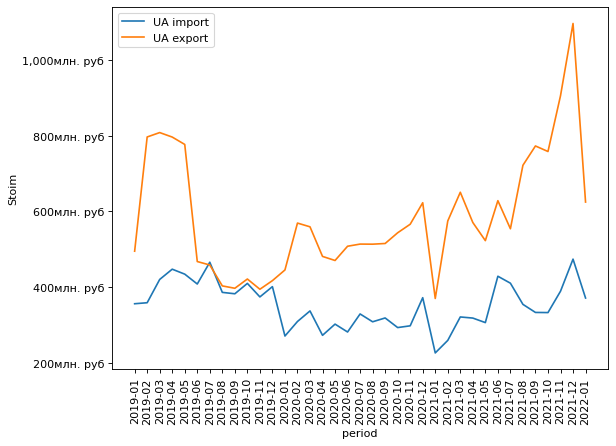

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6), dpi=80)

plot = sns.lineplot(data=pd.DataFrame(data.query("napr == 'ИМ' & nastranapr == 'UA'").groupby("period").Stoim.sum()),
                    x="period", y="Stoim", label='UA import')
plot = sns.lineplot(data=pd.DataFrame(data.query("napr == 'ЭК' & nastranapr == 'UA'").groupby("period").Stoim.sum()),
                    x="period", y="Stoim", label='UA export')

plt.setp(plot.get_xticklabels(), rotation=90)

ylabels = ['{:,.0f}'.format(x) + 'млн. руб' for x in plot.get_yticks()/1000000]
plot.set_yticklabels(ylabels)

plot